# Методы одномерного поиска

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve
import re

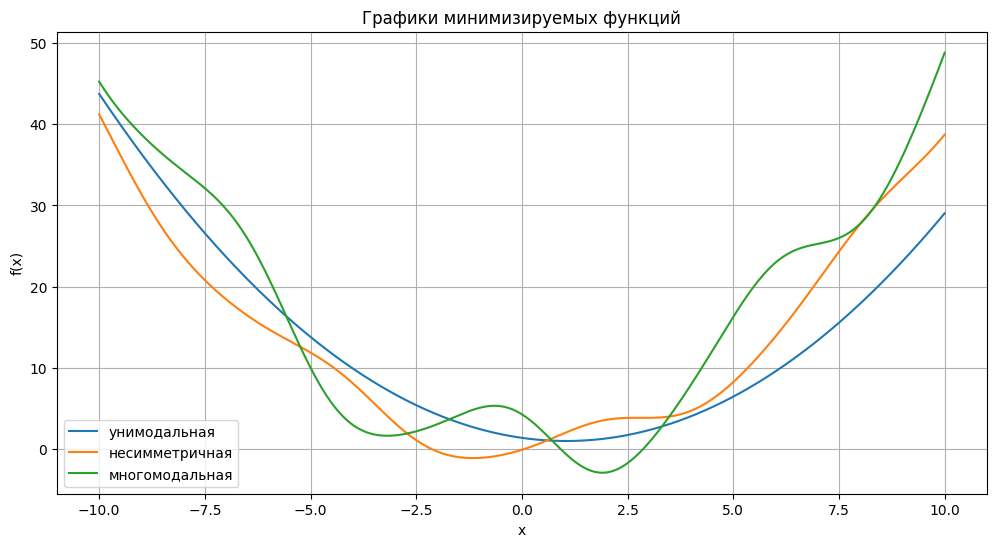

In [26]:
def f_unimod(x):
    return 0.35 * (x-1.05)**2 + 1
def f_nonsym(x):
    return 0.4 * x**2 + 2*np.sin(x) + 0.2*np.cos(2*x+2)
def f_mulmod(x):
    return 0.5 * x**2 + 5*np.sin(x-4) + 0.5*np.cos(2*x)

x_min = -10.0
x_max = 10.0
N = 10000
x = np.linspace(x_min, x_max, N)

G_plot = np.empty((3,), dtype='object')

G_plot[0] = f_unimod(x)
G_plot[1] = f_nonsym(x)
G_plot[2] = f_mulmod(x)

labels = ['унимодальная', 'несимметричная', 'многомодальная']

user_figsize = (12, 6)

plt.figure(figsize=user_figsize)
for lbl, G in zip(labels, G_plot):
    plt.plot(x, G, label=lbl)
plt.legend()
plt.title('Графики минимизируемых функций')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

In [27]:
max_iter = 200

## Метод дихотомии

In [28]:
def dihotom(f, x_min, x_max, max_iter, eps):
    x_l = x_min
    x_r = x_max
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    
    # Function compute counter.
    counter = 0
    for k in range(max_iter):
        x_center = (x_l + x_r)/2
        x_center_l = x_center - eps/2.01
        x_center_r = x_center + eps/2.01
        if f(x_center_l) > f(x_center_r):
            x_l = x_center_l
        else:
            x_r = x_center_r
        
        # Function is computed twice.
        counter += 2
        
        x_low.append(x_l)
        x_high.append(x_r)
        
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, k+1, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод золотого сечения

In [29]:
def golden(f, x_min, x_max, max_iter, eps):
    
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Initial step.
    x_l = x_min
    x_r = x_max
    delta = (x_r - x_l)/phi
    x_center_l = x_r - delta
    x_center_r = x_l + delta
    f_l = f(x_center_l)
    f_r = f(x_center_r)
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    # Function compute counter.
    counter = 2
    
    for k in range(max_iter):
        if f_l > f_r:
            f_l = f_r
            x_l = x_center_l
            delta = (x_r - x_l)/phi
            x_center_l = x_center_r
            x_center_r = x_l + delta
            f_r = f(x_center_r)
        else:
            f_r = f_l
            x_r = x_center_r
            delta = (x_r - x_l)/phi
            x_center_r = x_center_l
            x_center_l = x_r - delta
            f_l = f(x_center_l)
        
        x_low.append(x_l)
        x_high.append(x_r)
        
        counter += 1
        
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, k+1, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод Фибоначи

Генератор последовательности Фибоначи

In [30]:
def generate_fib_seq(K):
    seq = []
    seq.append(1) # F(0)=1
    seq.append(1) # F(1)=1
    for _ in range(K-2):
        seq.append(seq[-1] + seq[-2])
    return seq

Поиск порядкового номера числа Фибоначи

In [31]:
def find_fib_number(x):
    if x < 1:
        return 0  # F(0) = 1

    a, b = 1, 1
    n = 1  # номер текущего числа Фибоначчи (F(2) = 1)

    while b <= x:
        a, b = b, a + b
        n += 1

    return n

In [32]:
def fibonacci(f, x_min, x_max, max_iter, eps):
    # Estimate number of iterations and generate Fibonacci numbers.
    Fib = generate_fib_seq(5 + find_fib_number(int(abs(x_max - x_min) / eps + 0.5)))
    
    # Initial step.
    x_l = x_min
    x_r = x_max
    x_center_l = x_l + Fib[-3]/Fib[-1] * (x_r - x_l)
    x_center_r = x_l + Fib[-2]/Fib[-1] * (x_r - x_l)

    f_l = f(x_center_l)
    f_r = f(x_center_r)
    # Function compute counter.
    counter = 2
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    
    for k in range(max_iter):
        if f_l > f_r:
            f_l = f_r
            x_l = x_center_l
            x_center_l = x_center_r
            x_center_r = x_l + Fib[-3-1-k+1]/Fib[-3-1-k+2] * (x_r - x_l)
            #x_center_r = x_r - Fib[-3-1-k  ]/Fib[-3-1-k+2] * (x_r - x_l)
            f_r = f(x_center_r)
        else:
            f_r = f_l
            x_r = x_center_r
            x_center_r = x_center_l
            x_center_l = x_l + Fib[-3-1-k  ]/Fib[-3-1-k+2] * (x_r - x_l)
            #x_center_l = x_r - Fib[-3-1-k+1]/Fib[-3-1-k+2] * (x_r - x_l)
            f_l = f(x_center_l)
        x_low.append(x_l)
        x_high.append(x_r)
        
        counter += 1
        
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, k+1, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод парабол

Необходимо определить значения коэффициентов $a$, $b$, $c$ системы уравнений

$\left\{
\begin{aligned}
\bold{a} x_1^2 + \bold{b} x_1 + \bold{c} &= f(x_1), \\
\bold{a} x_2^2 + \bold{b} x_2 + \bold{c} &= f(x_2), \\
\bold{a} x_3^2 + \bold{b} x_3 + \bold{c} &= f(x_3)
\end{aligned}
\right.$

С этой целью обозначим

$F = \begin{bmatrix}
f(x_1) \\
f(x_2) \\
f(x_3)
\end{bmatrix}$,

$P = \begin{bmatrix}
a \\
b \\
c
\end{bmatrix}$,

$M_{sys} = \begin{bmatrix}
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
x_3^2 & x_3 & 1
\end{bmatrix}$.

Тогда, исходная система уравнений принимает вид

${M_{sys} \cdot P = F}$.

In [33]:
def parabol(f, x_min, x_max, max_iter, eps):
    
    x_low = []
    x_high = []
    x_low.append(x_min)
    x_high.append(x_max)
    
    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    # Function compute counter.
    counter = 3
    
    v_prev = x_min
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    for k in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        lu, piv = lu_factor(M_sys)
        [a, b, c] = lu_solve((lu, piv), F)

        if a != 0:
            v = -b/(2*a)
            f_v = f(v)
            counter += 1
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            #return M_sys[index_rise][0,1], k, counter, (x_low, x_high)
            print((F[0,0] - c)/b)
            return (F[0,0] - c)/b, k, counter, (x_low, x_high)
        
        F_rise = F[index_rise]
        F = F_rise.copy()
        F[-1] = f_v.copy()
        M_sys = M_sys[index_rise].copy()
        M_sys[-1,0] = v[0]**2
        M_sys[-1,1] = v[0].copy()
        
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        x_low.append(x_sorted[0].tolist()[0][0])
        x_high.append(x_sorted[2].tolist()[0][0])
        
        if np.abs(v-v_prev) < eps:
            return v[0], k+1, counter, (x_low, x_high)
        else:
            v_prev = v.copy()
    print('Solution has not been found (')

## Комбинированный метод Брента

In [46]:
def brent(f, x_min, x_max, max_iter, eps):
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Flag means the previous step was computed by the Golden Section.
    golden_sect_flag = False

    x_low = []
    x_high = []
    x_low.append(x_min)
    x_high.append(x_max)

    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    # Function compute counter.
    counter = 3

    v_prev = x_min
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    x_star = x_arr[1]
    x_star_prev = x_arr[1]

    for k in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        lu, piv = lu_factor(M_sys)
        [a, b, c] = lu_solve((lu, piv), F)

        if a != 0:
            v = -b/(2*a)
            f_v = f(v)
            counter += 1
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            #return M_sys[index_rise][0,1], k, counter, (x_low, x_high)
            print((F[0,0] - c)/b)
            return (F[0,0] - c)/b, k, counter, (x_low, x_high)
        
        F_rise = F[index_rise]
        if f_v < F_rise[-1]:
            F = F_rise.copy()
            F[-1] = f_v.copy()
            M_sys = M_sys[index_rise].copy()
            M_sys[-1,0] = v**2
            M_sys[-1,1] = v.copy()
            if np.abs(v - x_star) > np.abs(x_star - x_star_prev)/2:
                x_star_prev = x_star.copy()
                x_star = v.copy()
                golden_sect_flag = False
            else:
                print('golden2')
                if not golden_sect_flag:
                    # Sort x-values (ascending).
                    [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                    x_l = x_l[0,0]
                    x_r = x_r[0,0]
                    
                    delta = (x_r - x_l)/phi
                    x_center_l = x_r - delta
                    x_center_r = x_l + delta
                    f_l = f(x_center_l)
                    f_r = f(x_center_r)
                    
                    golden_sect_flag = True
                if f_l > f_r:
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                    M_sys[1,0] = x_center_r**2
                    M_sys[1,1] = x_center_r
                    F[1] = f_r
                    
                    f_l = f_r
                    x_l = x_center_l
                    x_center_l = x_center_r
                    x_center_r = x_l + (x_r - x_l)/phi
                    f_r = f(x_center_r)
                    
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                else:
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                    M_sys[1,0] = x_center_l**2
                    M_sys[1,1] = x_center_l
                    F[1] = f_l
                    
                    f_r = f_l
                    x_r = x_center_r
                    x_center_r = x_center_l
                    x_center_l = x_r - (x_r - x_l)/phi
                    f_l = f(x_center_l)
                    
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                
                x_star_prev = x_star.copy()
                x_star = M_sys[1,1] 
        else:
            print('golden1')
            if not golden_sect_flag:
                # Sort x-values (ascending).
                [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                x_l = x_l[0,0]
                x_r = x_r[0,0]
                
                delta = (x_r - x_l)/phi
                x_center_l = x_r - delta
                x_center_r = x_l + delta
                f_l = f(x_center_l)
                f_r = f(x_center_r)
                
                golden_sect_flag = True
            if f_l > f_r:
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
                M_sys[1,0] = x_center_r**2
                M_sys[1,1] = x_center_r
                F[1] = f_r
                
                f_l = f_r
                x_l = x_center_l
                x_center_l = x_center_r
                x_center_r = x_l + (x_r - x_l)/phi
                f_r = f(x_center_r)
                
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
            else:
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
                M_sys[1,0] = x_center_l**2
                M_sys[1,1] = x_center_l
                F[1] = f_l
                
                f_r = f_l
                x_r = x_center_r
                x_center_r = x_center_l
                x_center_l = x_r - (x_r - x_l)/phi
                f_l = f(x_center_l)
                
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
            
            x_star_prev = x_star.copy()
            x_star = M_sys[1,1]
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        if np.abs(v-v_prev) < eps:
            return v[0], k+1, counter, (x_low, x_high)
        else:
            v_prev = v.copy()
    print('Solution has not been found (')

## Минимизация унимодальных функций (симметричных и несимметричных)

In [35]:
func_type = f_unimod
#func_type = f_nonsym
match func_type.__name__:
    case 'f_unimod':
        func_comment = 'унимодальная'
    case 'f_nonsym':
        func_comment = 'несимметричная'

optim_methods = [dihotom, golden, fibonacci, parabol]
N_eps = 8
eps_var = np.logspace(-1,-8, N_eps)

interval_arr = np.empty((len(optim_methods),), dtype='object')
x_optim_arr = np.empty((len(optim_methods),), dtype='object')
iter_counter_arr = np.empty((len(optim_methods),), dtype='object')
func_counter_arr = np.empty((len(optim_methods),), dtype='object')

for mdx, opt_method in enumerate(optim_methods):
    x_optim_list = []
    iter_counter_list = []
    func_counter_list = []
    interval_list = np.empty((len(eps_var),2), dtype='object')
    for idx, eps in enumerate(eps_var):
        x_optim, iter_counter, func_counter, interval = \
            opt_method(f=func_type, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
        x_optim_list.append(x_optim)
        iter_counter_list.append(iter_counter)
        func_counter_list.append(func_counter)
        interval_list[idx][0] = interval[0]
        interval_list[idx][1] = interval[1]
        
    x_optim_arr[mdx] = x_optim_list
    iter_counter_arr[mdx] = iter_counter_list
    func_counter_arr[mdx] = func_counter_list
    interval_arr[mdx] = interval_list

Преобразуем в таблицы.

In [36]:
method_names = [func.__name__ for func in optim_methods]

x_optim_tbl = eps_var
for col in x_optim_arr:
    x_optim_tbl = np.vstack((x_optim_tbl, col))
x_optim_df = pd.DataFrame(x_optim_tbl.T, columns=['eps'] + method_names)

iter_counter_tbl = eps_var
for col in iter_counter_arr:
    iter_counter_tbl = np.vstack((iter_counter_tbl, col))
iter_counter_df = pd.DataFrame(iter_counter_tbl.T, columns=['eps'] + method_names)
iter_counter_df[method_names] = iter_counter_df[method_names].astype(int)

func_counter_tbl = eps_var
for col in func_counter_arr:
    func_counter_tbl = np.vstack((func_counter_tbl, col))
func_counter_df = pd.DataFrame(func_counter_tbl.T, columns=['eps'] + method_names)
func_counter_df[method_names] = func_counter_df[method_names].astype(int)

In [37]:
plot_list = [x_optim_df, iter_counter_df, func_counter_df]
plot_name = ['x-координата минимума функции', 'Количество итераций', 'Количество вычислений функции']
fig_name = ['x_optim', 'iter_number', 'func_calc_number']

tbl_title = [0] * 3

tbl_title[0] = 'Таблица оптимальных значений (' + func_comment + ' функция)'
tbl_title[1] = 'Таблица количества итераций (' + func_comment + ' функция)'
tbl_title[2] = 'Таблица количества вычислений функции (' + func_comment + ' функция)'

for tbl_tlt, plt_lst in zip(tbl_title, plot_list):
    print(tbl_tlt)
    display(plt_lst)

Таблица оптимальных значений (унимодальная функция)


,eps,dihotom,golden,fibonacci,parabol
0,1.000000e-01,1.049896,1.052449,1.051972,1.05
1,1.000000e-02,1.049988,1.049649,1.049630,1.05
2,1.000000e-03,1.049998,1.049805,1.049802,1.05
3,1.000000e-04,1.050000,1.050012,1.050012,1.05
4,1.000000e-05,1.050000,1.050000,1.050000,1.05
5,1.000000e-06,1.050000,1.050000,1.050000,1.05
6,1.000000e-07,1.050000,1.050000,1.050000,1.05
7,1.000000e-08,1.050000,1.050000,1.050000,1.05


Таблица количества итераций (унимодальная функция)


,eps,dihotom,golden,fibonacci,parabol
0,1.000000e-01,16,12,12,2
1,1.000000e-02,19,16,16,2
2,1.000000e-03,22,21,21,2
3,1.000000e-04,26,26,26,2
4,1.000000e-05,29,31,31,2
5,1.000000e-06,32,35,35,2
6,1.000000e-07,36,40,40,2
7,1.000000e-08,39,45,45,2


Таблица количества вычислений функции (унимодальная функция)


,eps,dihotom,golden,fibonacci,parabol
0,1.000000e-01,32,14,14,5
1,1.000000e-02,38,18,18,5
2,1.000000e-03,44,23,23,5
3,1.000000e-04,52,28,28,5
4,1.000000e-05,58,33,33,5
5,1.000000e-06,64,37,37,5
6,1.000000e-07,72,42,42,5
7,1.000000e-08,78,47,47,5


### Графики динамики интервала неопределенности

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\rgorbunov\AppData\Local\Temp\ipykernel_9048\4114923772.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


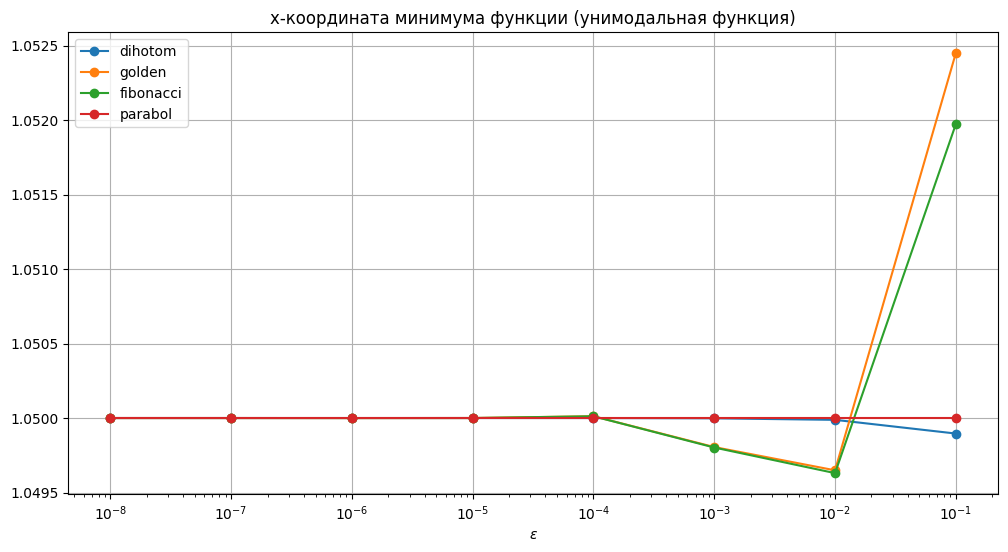

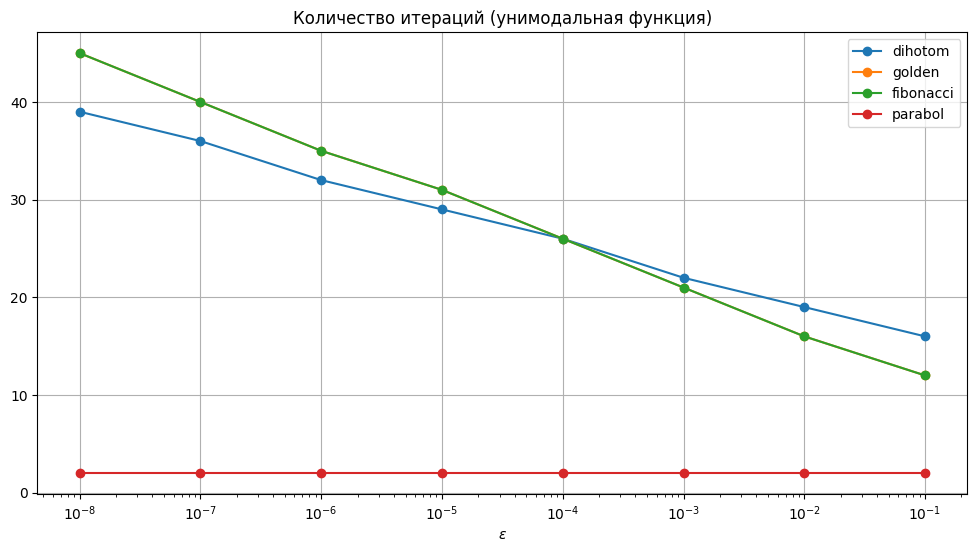

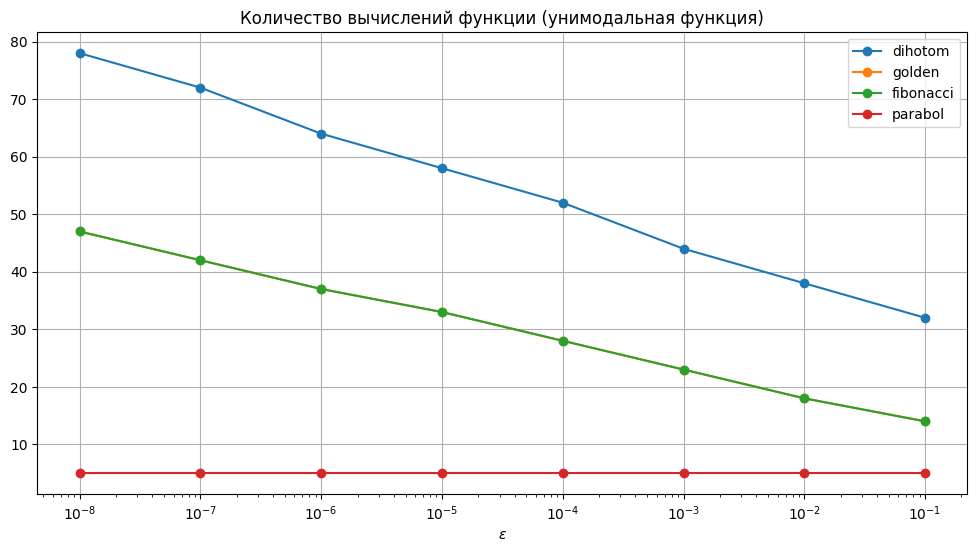

In [38]:
for plt_lst, plt_name, fig_name_idx in zip(plot_list, plot_name, fig_name):
    plt.figure(figsize=user_figsize)
    plt.plot(eps_var, plt_lst[method_names], marker='.', markersize=12)
    plt.title(plt_name + ' (' + func_comment + ' функция)')
    plt.grid()
    plt.xscale('log')
    plt.xlabel('$\epsilon$')
    plt.legend(method_names)
    plt.savefig('readme_img/' + fig_name_idx + '_' + func_type.__name__ + '.png', bbox_inches='tight')
    plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\rgorbunov\AppData\Local\Temp\ipykernel_9048\1060068682.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon =$' + str(eps) + ' (' + func_comment + ' функция)')
C:\Users\rgorbunov\AppData\Local\Temp\ipykernel_9048\1060068682.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$x_{min} \longleftrightarrow x_{max}$')


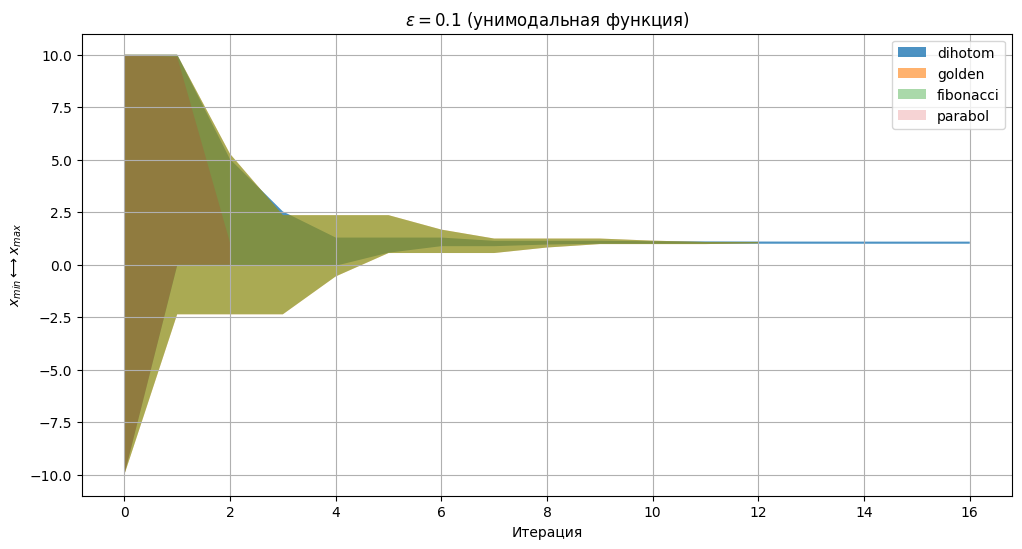

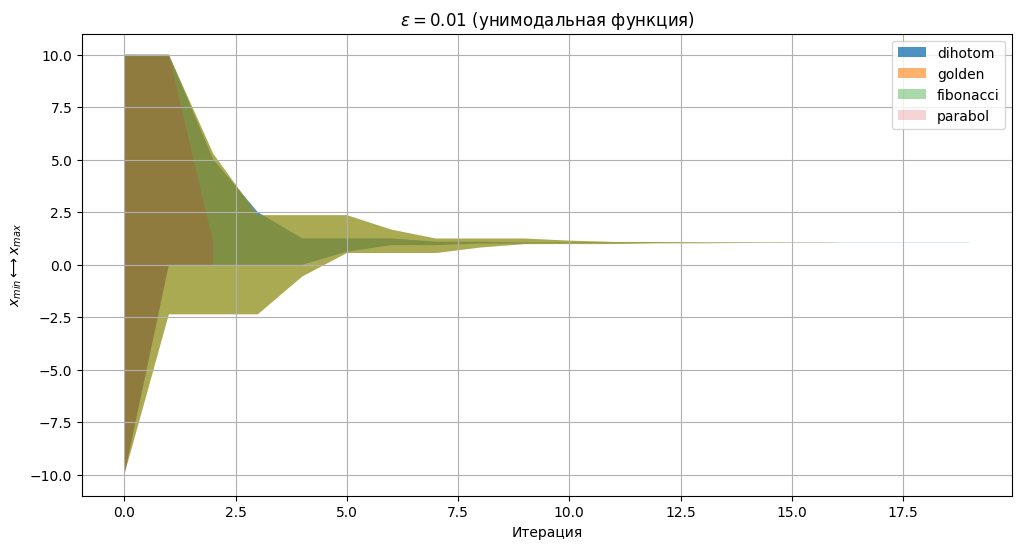

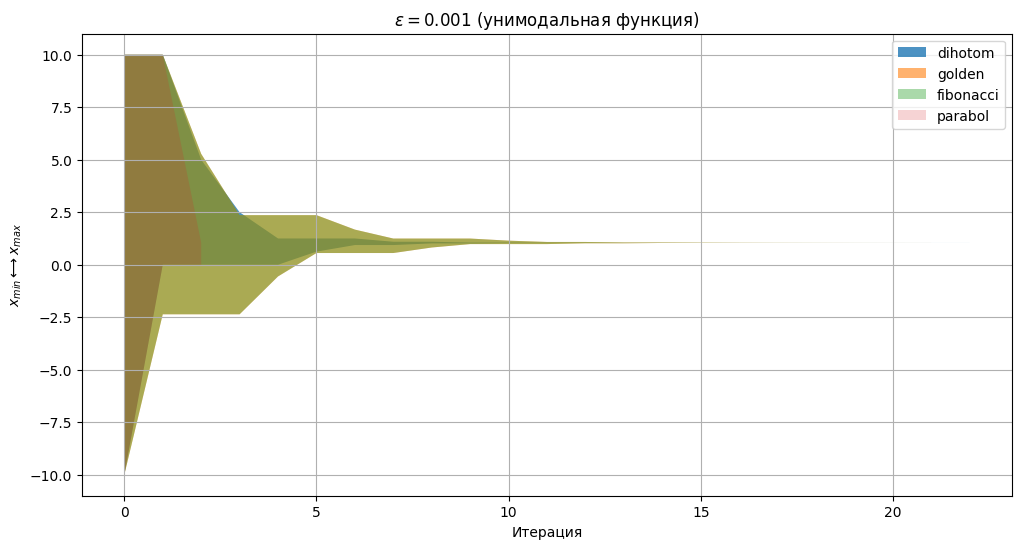

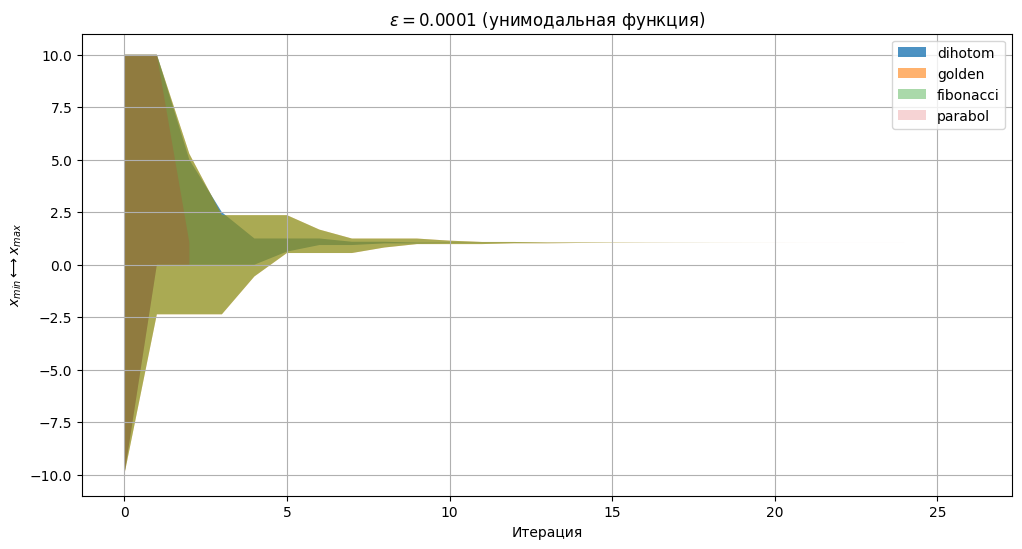

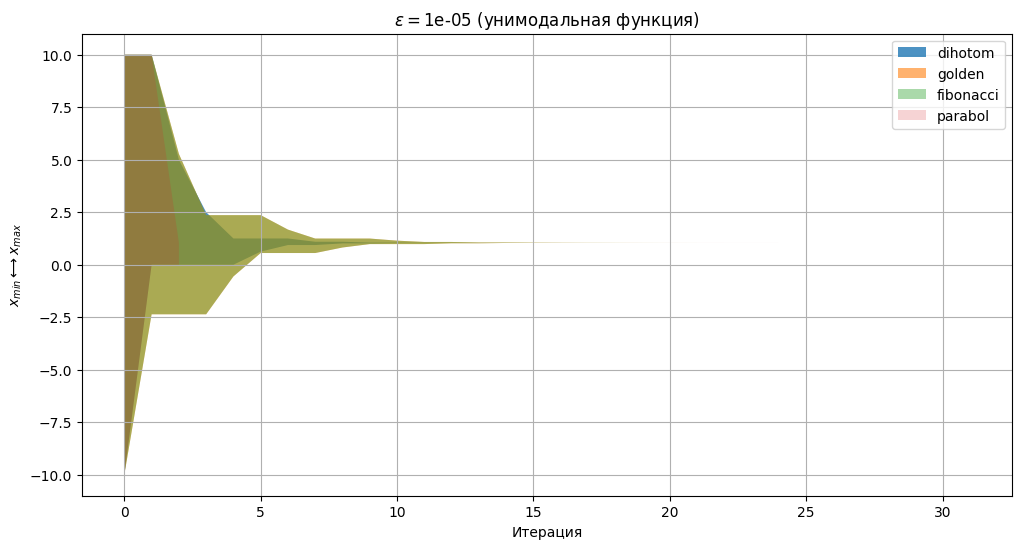

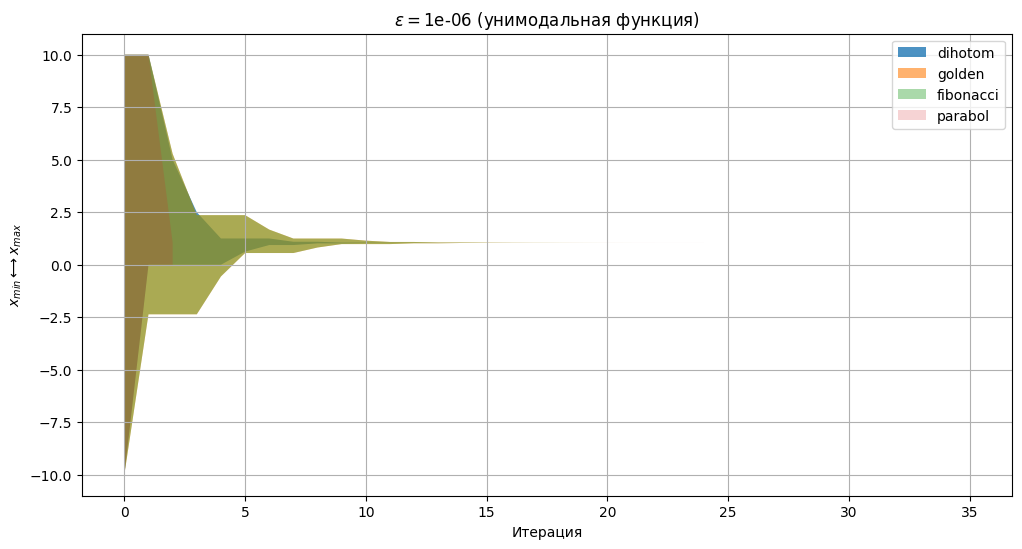

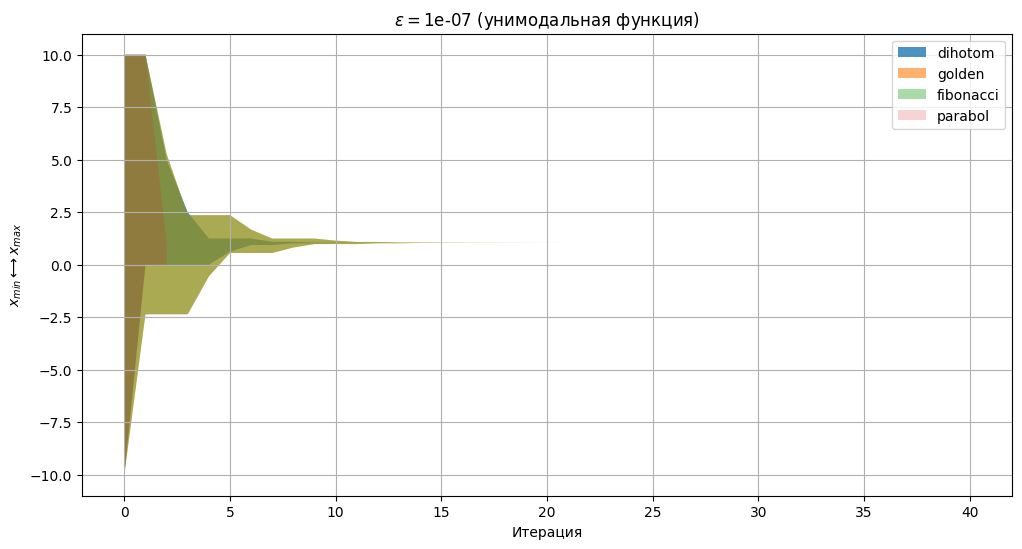

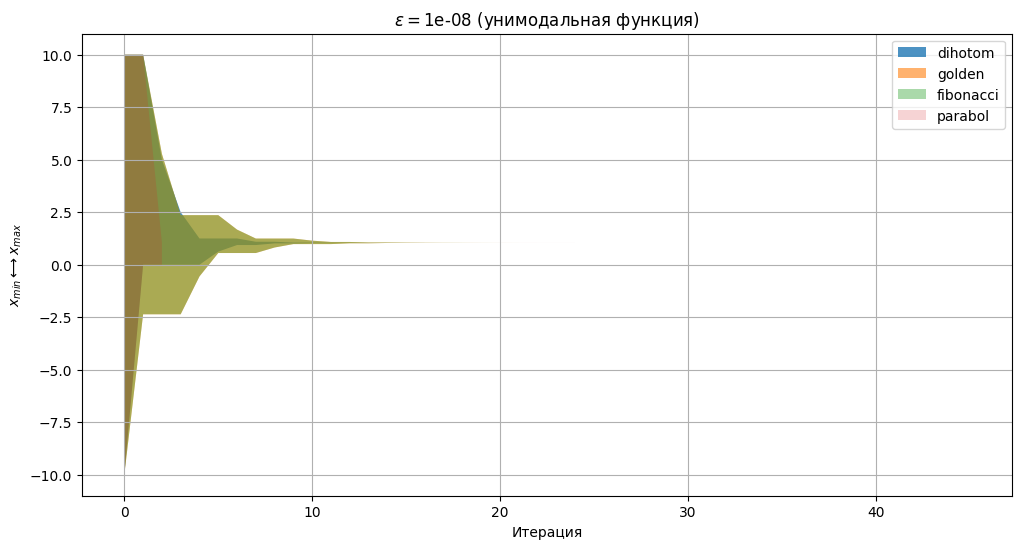

In [39]:
for idx, eps in enumerate(eps_var):
    plt.figure(figsize=user_figsize)
    for mdx, meth_name in enumerate(method_names):
        plt.fill_between(list(range(len(interval_arr[mdx][idx][0]))), interval_arr[mdx][idx][0], interval_arr[mdx][idx][1], alpha=(0.8 - 0.2 * mdx), label=meth_name)
    plt.grid()
    plt.title('$\epsilon =$' + str(eps) + ' (' + func_comment + ' функция)')
    plt.xlabel('Итерация')
    plt.ylabel('$x_{min} \longleftrightarrow x_{max}$')
    plt.legend()
    plt.savefig('readme_img/interval_' + 'eps_' + str(eps) + '_' + func_type.__name__ + '.png', bbox_inches='tight')
    plt.show()

## Минимизация многомодальной функции с предварительной разведкой пассивным методом

In [40]:
def passive_search(f, x_min, x_max, eps):
    # At least 10 intervals.
    if (x_max - x_min)/eps < 10:
        eps = (x_max - x_min)/10
    N = int((x_max - x_min)/eps + 0.5)
    x = []
    for n in range(N):
        x.append(x_min + n*eps)
    y = f(np.array(x))
    indx_min = np.argmin(y)
    
    if (indx_min - 1) >= 0:
        x_min_local = x[indx_min - 1]
    else:
        x_min_local = x[0]
    
    if (indx_min + 1) < len(x):
        x_max_local = x[indx_min + 1]
    else:
        x_max_local = x[-1]
    return x_min_local, x_max_local

In [41]:
search_opt = ['direct', 'pre-searched']

x_optim_arr = np.empty((len(search_opt),), dtype='object')

for mdx, _ in enumerate(search_opt):
    x_optim_list = []
    for idx, eps in enumerate(eps_var):
        if mdx == 0:
            x_optim, _, _, _ = golden(f=f_mulmod, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
        else:
            x_min_local, x_max_local = passive_search(f_mulmod, x_min, x_max, eps=eps*100)
            x_optim, _, _, _ = golden(f=f_mulmod, x_min=x_min_local, x_max=x_max_local, max_iter=max_iter, eps=eps)
        x_optim_list.append(x_optim)
        
    x_optim_arr[mdx] = x_optim_list

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\rgorbunov\AppData\Local\Temp\ipykernel_9048\2355534284.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


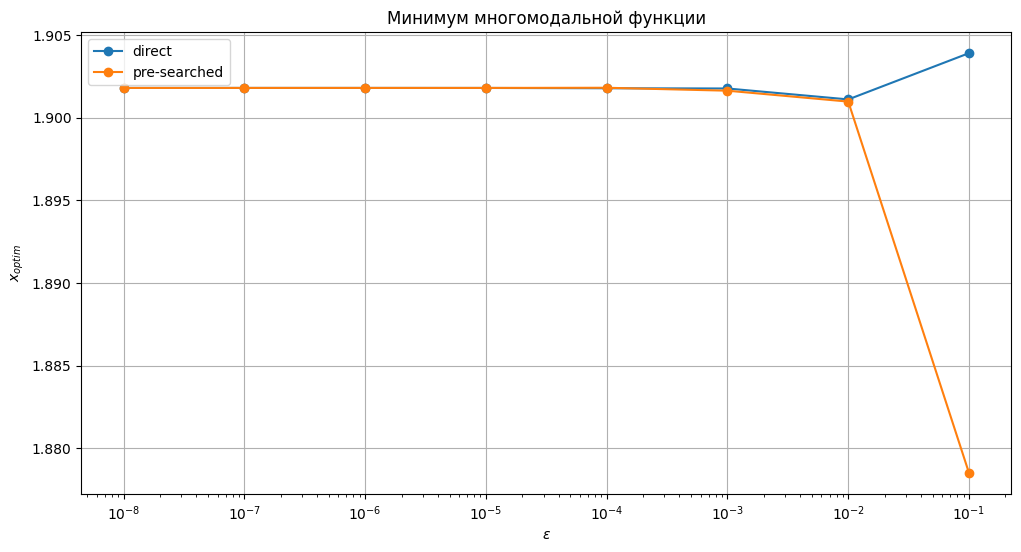

In [42]:
plt.figure(figsize=user_figsize)
for mdx, opt in enumerate(search_opt):
    plt.plot(eps_var, x_optim_arr[mdx], marker='.', markersize=12, label=opt)
plt.title('Минимум многомодальной функции')
plt.grid()
plt.xscale('log')
plt.ylabel('$x_{optim}$')
plt.xlabel('$\epsilon$')
plt.legend(search_opt)
plt.savefig('readme_img/x_optim_multimode.png', bbox_inches='tight')
plt.show()

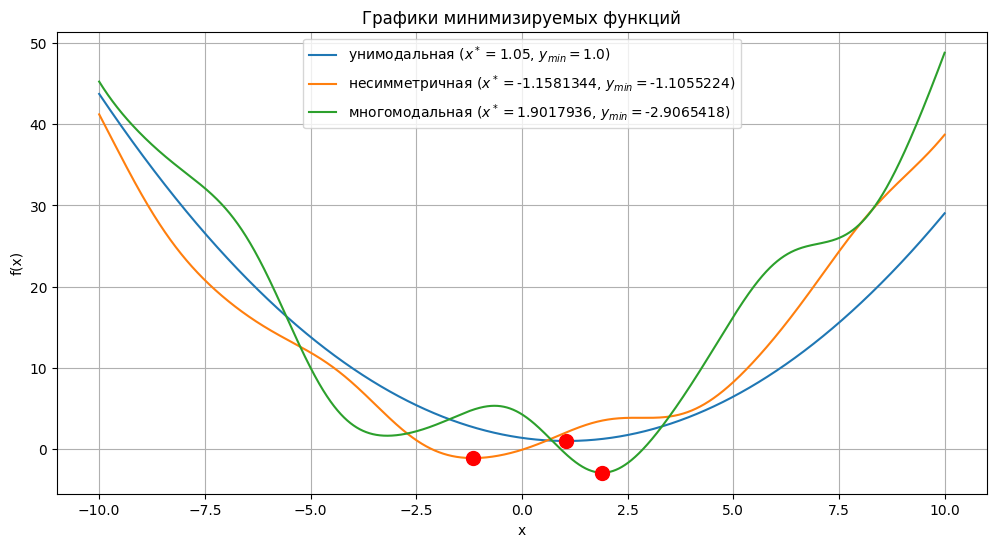

In [43]:
x_optim_gr = [0]*3
y_optim_gr = [0]*3

x_optim_gr[0], _, _, _ = dihotom(f=f_unimod, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=1e-8)
x_optim_gr[1], _, _, _ = dihotom(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=1e-8)
x_optim_gr[2] = x_optim_arr[1][-1]
y_optim_gr[0] = f_unimod(x_optim_gr[0])
y_optim_gr[1] = f_nonsym(x_optim_gr[1])
y_optim_gr[2] = f_mulmod(x_optim_gr[2])

plt.figure(figsize=user_figsize)
for lbl, G, x_opt, y_opt in zip(labels, G_plot, x_optim_gr, y_optim_gr):
    plt.plot(x, G, label=lbl + ' ($x^*=$' + str(np.round(x_opt,7)) + ', $y_{min}=$' + str(np.round(y_opt,7)) + ')')
    plt.plot(x_opt, y_opt, 'ro', markersize=10)
plt.legend()
plt.title('Графики минимизируемых функций')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.savefig('readme_img/functions.png', bbox_inches='tight')
plt.show()

# Генератор таблиц в приложения

In [44]:
def update_readme_section(tbl_df, readme_path, tbl_name, section):
    markdown_table = tbl_df.to_markdown(index=False)

    with open(readme_path, 'r', encoding="utf-8-sig") as f:
        content = f.read()

    # Define start and end markers.
    start_marker = f'<!-- START_{section.upper()} -->'
    end_marker = f'<!-- END_{section.upper()} -->'

    # Wrap the table with headers and markers.
    new_section = f'\n{start_marker} \n### {tbl_name}\n{markdown_table}\n{end_marker}'
    
    # Remove any previous content between the markers.
    pattern = re.compile(f'{re.escape(start_marker)}.*?{re.escape(end_marker)}', re.DOTALL)
    updated_content = pattern.sub("", content)

    # Insert the new section to the end of the file.
    updated_content += new_section

    with open(readme_path, 'w', encoding="utf-8-sig") as f:
        f.write(updated_content)

In [45]:
section_names = ['x_optim', 'iter_counter', 'func_counter']

for plt_lst, tbl_tlt, section in zip(plot_list, tbl_title, section_names):
    update_readme_section(plt_lst, readme_path='README.md', tbl_name=tbl_tlt, section=section + '_' + func_type.__name__)